In [24]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D

# $ I $

### Pocatecni podminky

In [25]:
pocet_castic = 500
teplota = 170                             # [K]
hmotnost_argonu = 39.948*1.6605390666e-27 # [kg]
hustota_molarni = 0.14287 * 10**3         # N \V [mol/ m**3]

avogadrova_konst = 6.022E23
ciselna_hustota = hustota_molarni * avogadrova_konst  
objem = pocet_castic / ciselna_hustota  
strana_boxu = objem**(1/3)

boltzmanova_konstanta = 1.380649e-23      # [J*K^-1]
epsilon = 119.8 * boltzmanova_konstanta # [J/K]
sigma = 0.341E-9                        # [m]

r_cut = 5*sigma
tau = 0.1E-12     # piko 
delta_t = 2E-15   # femto  
r_ar = 71E-12                           # [m]

In [26]:
strana_boxu

1.7978884239760234e-08

### Generace pocatecnich poloh

In [27]:
def generace_poc_poloh(pocet_castic, strana_boxu, sigma):
    polohy = np.random.uniform(0, strana_boxu, (pocet_castic, 3))
    return polohy

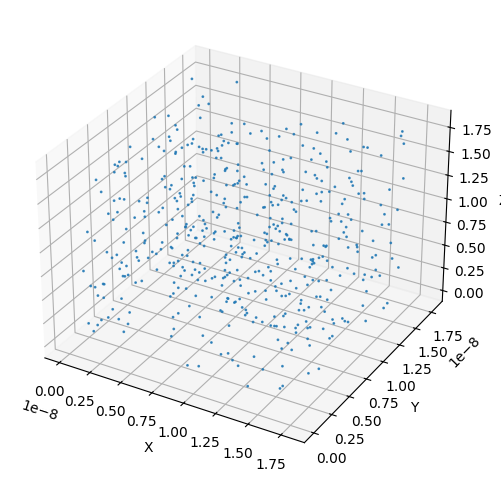

In [28]:
polohy = generace_poc_poloh(pocet_castic, strana_boxu, sigma)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(polohy[:, 0], polohy[:, 1], polohy[:, 2], s=1, alpha=0.8)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


In [29]:
rozdily = polohy[:, np.newaxis, :] - polohy[np.newaxis, :, :]
abs_vzdal = np.linalg.norm(rozdily, axis=-1)

print("Минимальное расстояние:", np.min(abs_vzdal[np.triu_indices(len(polohy), k=1)]))
print("Максимальное расстояние:", np.max(abs_vzdal[np.triu_indices(len(polohy), k=1)]))

Минимальное расстояние: 2.507481006623085e-10
Максимальное расстояние: 2.9175701301484533e-08


### Generace rychlosti pomoci - Ekviparticni teoriumu Max Boltzman
$ \frac{1}{2} m \vec v^2  =\frac{1}{2} m (v^2_{x} +v^2_{y} +v^2_{z}) = \frac{1}{2} k_b T $,   
    kde $\frac{1}{2} k_b T $ - prvni stupen voltosti

In [30]:
def generace_poc_rychlosti(pocet_castic, hmotnost_argonu, boltzmanova_konstanta, teplota):
    odchylka_rychlosti = np.sqrt(boltzmanova_konstanta * teplota / hmotnost_argonu)
    rychlosti = np.random.normal(0, odchylka_rychlosti, (pocet_castic, 3))
    rychlosti -= np.mean(rychlosti,axis= 0) # aby sum v = 0, system se nepochybuje
    return rychlosti

Zobrazim a overim sprravne rozlozeni pocatecnich rychlosti, kde hustota pravdepodobnosti Max B.

$f(v) = 4 \pi v^2 \left( \frac{m}{2 \pi k_B T} \right)^{3/2} \exp\left(-\frac{m v^2}{2 k_B T}\right)$


In [78]:
def plot_rychlosti(rychlosti, teplota, hmotnost_argonu, boltzmannova_konstanta):
    modul_rychl = np.sqrt(np.sum(rychlosti**2, axis = 1))
    
    v = np.linspace(0, np.max(modul_rychl), 100)
    f_v = 4 * np.pi * (v**2) * (hmotnost_argonu / (2 * np.pi * boltzmannova_konstanta * teplota))**1.5 \
        * np.exp(-hmotnost_argonu * v**2 / (2 * boltzmannova_konstanta * teplota))
    
    plt.hist(modul_rychl, density= True, bins = 40)
    plt.plot(v, f_v, linewidth = 2)
    plt.xlabel("Rychlost [m/s]")
    plt.ylabel("Hustota pravdepodobnosti")
    plt.title("Rozlozeni rychlosti")
    plt.show()    

[ 1.79056769e-12 -6.25277607e-13 -3.41060513e-13]


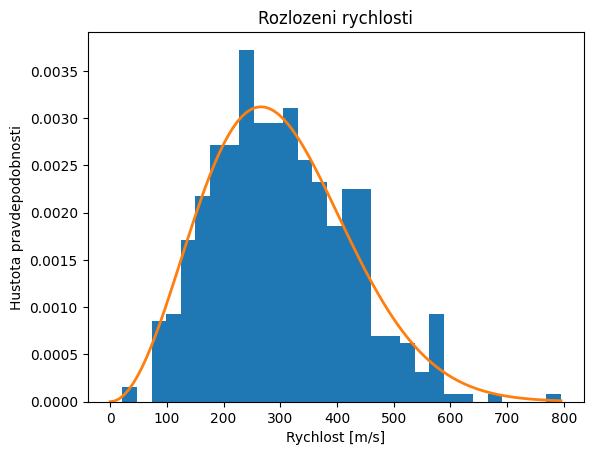

In [32]:
rychlosti = generace_poc_rychlosti(pocet_castic, hmotnost_argonu, boltzmanova_konstanta, teplota)
celkova_rychlost = np.sum(rychlosti, axis=0)
print(celkova_rychlost) # je to skoro 0
plot_rychlosti(rychlosti, teplota, hmotnost_argonu, boltzmanova_konstanta)

### Vypocet vzdalenosti dvou castic metodou obrazu

$ r_{abs} = |\vec{r_{1}} - \vec{r_{2}}| = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2} $

[N,1,3] - [1, N, 3] = [N,N,3] * pro 3c= [ [[1-1][1-2][1-3]] , [2-1][2-2][2-3]... ]

maska vynecha doubly pro pary a, vzdalenosti castic s sebou, nad diag prvky

In [33]:
def vypocet_vzdalenosti(polohy, strana_boxu, r_cut):
    rozdily = polohy[:, np.newaxis, :] - polohy[np.newaxis, :, :] 
    rozdily -= np.round(rozdily / strana_boxu) * strana_boxu 
    i, j = np.triu_indices(len(polohy), k=1) # indxy unikatnich paru
    
    vektor_vzdalenosti = rozdily[i, j]  
    abs_vzdal = np.linalg.norm(vektor_vzdalenosti, axis=1) 
    
    maska = abs_vzdal < r_cut
    return abs_vzdal[maska], vektor_vzdalenosti[maska], i[maska], j[maska]

# $II$

#### Postup Rychlostni Verlet:
1. Inic. P.P.: $ \vec{r_0}, \vec{V_0}, t, \Delta t $
2. Vypocet poc. polohy pro $ t = -\Delta t: \vec{r_{-\Delta t}}=\vec{r_0}- \Delta t * \vec{V_0}$

3. Vypocet poc. sil na zaklade poc. poloh:
    $ \vec F_0 = - \nabla U_{r_0}$ 
4. Iterace prez casove kroky:

    a) Aktualizace poloh pomoci Verleta:

    $r(t+ \Delta t)$
    
    b) Aktualizace sily pusobici mezi castice pomoci LJ:
    
     $ \vec F(t+\Delta t) = - \nabla U(r(t +\Delta t))$

    c) Aktualizace rychlosti

    $\vec V(t+ \Delta t) = \vec V(t) + \frac{\vec F(t) + \vec F(t+\Delta t)}{2m} * \Delta t $


## 2

In [34]:
def vyp_predchozich_polohh(polohy, delta_t, rychlosti):
    predchozi_polohy = polohy - delta_t * rychlosti
    return predchozi_polohy

## 4a
Aktualizace poloh
$\vec r(t+\Delta t) = 2 \vec r(t) - \vec r(t - \Delta t) + \frac{\vec F(t)}{m}  (\Delta t)^2$

In [35]:
def posun_castic(akt_polohy, pred_polohy, delta_t, hmotnost_argonu, strana_boxu, sily_mezi_castice):
    nove_polohy = 2 * akt_polohy - pred_polohy  + (sily_mezi_castice/hmotnost_argonu) * delta_t**2 
    nove_polohy %= strana_boxu
    return nove_polohy

## 4b
Sily mezi castice:
$ \vec F_{ij} = - \nabla U_{ij}$ 

LJ potencialni energie paru - mezi atomove iterakce:
$ U_{r_{ij}} = 4 \epsilon [ (\frac {\sigma}{r_{abs}})^{12} - (\frac {\sigma}{r_{abs}})^{6} ] $

Sila:
$ F_{ij} = 24 \epsilon [ (2\frac {\sigma}{r_{abs}})^{12} - (\frac {\sigma}{r_{abs}})^{6} ] \frac{\vec r_{ij}}{r_{abs}^2} $

kde $\vec r_{ij} = \vec r_i - \vec r_j$, a $\vec r = |\vec r_{ij}|$


LJ paru:$ U_{r_{ij}} = 4 \epsilon \sum{[ (\frac {\sigma}{r_{abs}})^{12} - (\frac {\sigma}{r_{abs}})^{6} ]} $

$U_{total} = \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} U_{r_{ij}}  $ 

In [36]:
def vyp_sil_pot_e_mezi_castice(polohy, pocet_castic, epsilon, sigma, r_cut, strana_boxu):
    abs_vzdal, vektor_vzdalenosti, i, j = vypocet_vzdalenosti(polohy, strana_boxu, r_cut)

    if vektor_vzdalenosti.size == 0:
        return np.zeros((pocet_castic, 3)), 0.0, vektor_vzdalenosti, np.zeros_like(polohy)

    r6 = (sigma / abs_vzdal)**6
    r12 = r6**2
    
    sila_m = 24 * epsilon * (2 * r12 - r6) / abs_vzdal**2  # Величина силы (N,)

    sila = sila_m[:, np.newaxis] * vektor_vzdalenosti  # (N, 3)
    sily_mezi_castice = np.zeros((pocet_castic, 3))
    np.add.at(sily_mezi_castice, i, sila) 
    np.add.at(sily_mezi_castice, j, -sila)
    
    pot_en_paru = 4*epsilon * (r12 - r6)
    celk_pot_e = np.sum(pot_en_paru)
      
    return sily_mezi_castice, celk_pot_e, vektor_vzdalenosti, sila

$E_{kin} = \frac{1}{2} \sum m |\vec V|^2 $

$ P_{kin} = \frac{N k_b T}{V}$ $ P_{pot} = \frac{1}{3V} \sum_{i=1}^N \sum_{j=i+1}^N \vec r_{ij} \vec F_{ij} $

In [37]:
def vyp_kin_e_tlaku(rychlosti, hmotnost_argonu, vektor_vzdalenosti, sily_mezi_castice, pocet_castic, boltzmanova_konstanta,akt_t, objem):
    e_kin = 0.5 * hmotnost_argonu * np.sum(np.linalg.norm(rychlosti, axis=1)**2)
    p_kin = (pocet_castic*boltzmanova_konstanta*akt_t) / objem
    
    if vektor_vzdalenosti.size == 0:
        return p_kin, e_kin
    
    p_pot = np.sum(np.sum(vektor_vzdalenosti * sily_mezi_castice, axis=1)) / (3 * objem)
    p_tot = p_kin + p_pot
    
    return p_tot, e_kin

## 4c

In [38]:
def nove_rychlosti(akt_rychlosti, akt_sily, pred_sily, hmotnost_argonu, delta_t ):
    rychlosti = akt_rychlosti + ((akt_sily + pred_sily) / (2 * hmotnost_argonu)) * delta_t
    return rychlosti

# $III$
## Verlet s korekci rychlosti pomoci termostatu

Berendsen thermostat - zmenena rychlosti pro dodreni pozadovane teploty
#### $ \frac{dT}{dt} = \frac{T_0 - T}{\tau } $, kde $ \Delta t = \tau$, $T_0$ - pozadovana teplota(170), $T$ - aktualni teplota

Pomoci Eulerove Metody upravim do tvaru:

$T(t+\Delta t) = T(t) + \frac{\Delta }{\tau} (T_0-T(t))$

kde $ T = \frac{1}{3Nk_B} \sum_{i=1}^N m |\vec V_i|^2 $, koef. mapovani $\lambda  = \sqrt{\frac{T(t+\Delta t)}{T(t)}} $, 

po dosazeni a upraveni $ \lambda = \sqrt{1+ \frac{\Delta t}{\tau} (\frac{T_0}{T(t)}-1)}$ jestli  $\lambda < 1$ - snizeni T, $\lambda > 1$ - zvyseni T 

$\vec V_i \to \lambda \vec V_i$

In [39]:
def berendsen_thermostat(aktualni_t, pozadovane_t, tau, delta_t, rychlosti):
    lambda_factor = np.sqrt(1 + (delta_t/tau) * (pozadovane_t/aktualni_t -1))
    rychlosti *= lambda_factor
    return rychlosti 

In [40]:
def vyp_aktualni_t(boltzmanova_konstanta, pocet_castic, hmotnost_argonu, rychlosti):
    rychl_kv = np.sum(rychlosti**2, axis = 1)
    suma_rychlosti = np.sum(rychl_kv)
    aktualni_t = (hmotnost_argonu * suma_rychlosti) / (3* pocet_castic*boltzmanova_konstanta)  
    return aktualni_t

# $IV$

Vypocet rdf
$n(r)$ - pocet castic ve vzdalenosti r, $\rho = \frac{N}{V}$, $V(r) $- objem sfericke slupky

$ g(r) = \frac{n(r)}{\rho V(r)}$

$V(r)= \frac{4}{3}\pi [(r+\Delta r)^3 -r^3] = 4\pi r^2 \Delta r $

In [41]:
def vyp_rdf(pocet_castic, strana_boxu, r_cut, polohy, pocet_dilku):
    hustota = pocet_castic/(strana_boxu)**3
    #delta_r = r_cut/pocet_dilku
    hranice = np.linspace(0, r_cut, pocet_dilku + 1)
    #centr_slupky = 0.5 * (hranice[:-1] + hranice[1:])  

    rozdily = polohy[:, np.newaxis, :] - polohy[np.newaxis, :, :]
    rozdily -= np.round(rozdily / strana_boxu) * strana_boxu
    abs_vzdal = np.linalg.norm(rozdily, axis=-1)

    i, j = np.triu_indices(len(polohy), k=1)
    abs_vzdal = abs_vzdal[i, j]

    n_castic_v_slupkach, _ = np.histogram(abs_vzdal, bins=hranice)

    # V_r = 4 * np.pi * centr_slupky**2 * delta_r
    V_r = (4/3) * np.pi * (hranice[1:]**3 - hranice[:-1]**3)
    g_r = n_castic_v_slupkach / (V_r * hustota) / pocet_castic 
    
    return g_r 

In [42]:
def precist_posledni_polohy(nazev_souboru, pocet_castic):
    with open(nazev_souboru, "r") as soubor:
        radky = soubor.readlines()[-(pocet_castic + 2):]

    posledni_pozice = []
    for radek in radky:
        castice = radek.split()
        if len(castice) == 4:
            x, y, z = map(float, castice[1:])
            posledni_pozice.append([x, y, z])
    return np.array(posledni_pozice)

In [43]:
nazev_souboru = "Vysleden_polohy_po_50000_iter.xyz"

In [44]:
# nazev_souboru = "Vysleden_polohy_po_50000_iter.xyz"
# akt_polohy = precist_posledni_polohy(nazev_souboru, pocet_castic)
# pred_rych = generace_poc_rychlosti(pocet_castic, hmotnost_argonu, boltzmanova_konstanta, teplota)

# Q = pocet_castic* boltzmanova_konstanta * teplota * tau**2
# koef_skalovani =  0

pocet_ekv_kroku = 60000
pocet_sim_kroku =  100000
pocet_dilku = 100
teploty_pred_zmenou = []
prubeh_e_pot = []
prubeh_e_kin = []
tlak_systemu = []
rdf_rozlozeni = np.zeros(pocet_dilku)


akt_polohy = generace_poc_poloh(pocet_castic, strana_boxu, sigma)
pred_rych = generace_poc_rychlosti(pocet_castic, hmotnost_argonu, boltzmanova_konstanta, teplota) #jsou to aktualni polohy ale tahkhle pojmenovane pro vypocet akt rychlosti V(t+deltat) 
pred_polohy = vyp_predchozich_polohh(akt_polohy, delta_t, pred_rych)
pred_sily, en_pot, vektor_vzdalenosti, sila = vyp_sil_pot_e_mezi_castice(pred_polohy, pocet_castic, epsilon, sigma, r_cut, strana_boxu)


for i in range(pocet_ekv_kroku):
    akt_polohy = posun_castic(akt_polohy, pred_polohy, delta_t, hmotnost_argonu, strana_boxu, pred_sily)
    akt_sily, en_pot, vektor_vzdalenosti, sila = vyp_sil_pot_e_mezi_castice(akt_polohy, pocet_castic, epsilon, sigma, r_cut, strana_boxu)
    akt_rychl = nove_rychlosti(pred_rych, akt_sily, pred_sily, hmotnost_argonu, delta_t )
    #
    if i%100 ==0:
        akt_t = vyp_aktualni_t(boltzmanova_konstanta, pocet_castic, hmotnost_argonu, akt_rychl)
        akt_rychl = berendsen_thermostat(akt_t, teplota, tau, delta_t, akt_rychl)


for i in range(pocet_sim_kroku):
    akt_polohy = posun_castic(akt_polohy, pred_polohy, delta_t, hmotnost_argonu, strana_boxu, pred_sily)
    akt_sily, en_pot, vektor_vzdalenosti, sila = vyp_sil_pot_e_mezi_castice(akt_polohy, pocet_castic, epsilon, sigma, r_cut, strana_boxu)
    akt_rychl = nove_rychlosti(pred_rych, akt_sily, pred_sily, hmotnost_argonu, delta_t )
    #
    if i%100 ==0:
        akt_t = vyp_aktualni_t(boltzmanova_konstanta, pocet_castic, hmotnost_argonu, akt_rychl)
        tlak, kin_e = vyp_kin_e_tlaku(akt_rychl, hmotnost_argonu, vektor_vzdalenosti, sila, pocet_castic, boltzmanova_konstanta,akt_t, objem)
        akt_rychl = berendsen_thermostat(akt_t, teplota, tau, delta_t, akt_rychl)
        
        prubeh_e_kin.append(kin_e)
        tlak_systemu.append(tlak)    
        teploty_pred_zmenou.append(akt_t)
        prubeh_e_pot.append(en_pot)
    
    pred_polohy[:] = akt_polohy
    pred_sily[:] = akt_sily
    pred_rych[:] = akt_rychl
    
    if i%10 ==0:
        g_r = vyp_rdf(pocet_castic, strana_boxu, r_cut,akt_polohy, pocet_dilku)
        rdf_rozlozeni += g_r

Text(0.5, 1.0, 'RDF')

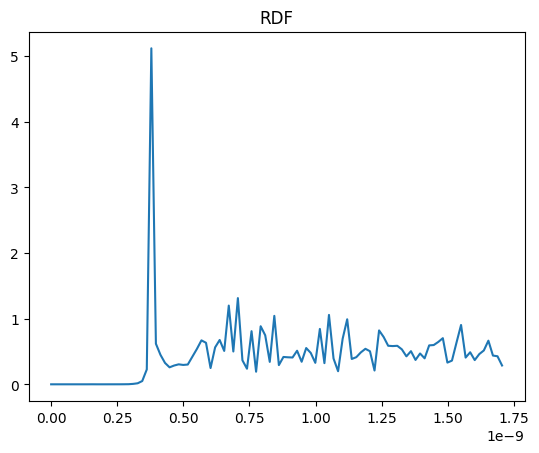

In [55]:
hranice = np.linspace(0, r_cut, pocet_dilku)
rdf_skalovani = rdf_rozlozeni / (pocet_sim_kroku // 10)
plt.plot(hranice, rdf_skalovani)
plt.title("RDF")

Text(0.5, 1.0, 'Tlak systemu')

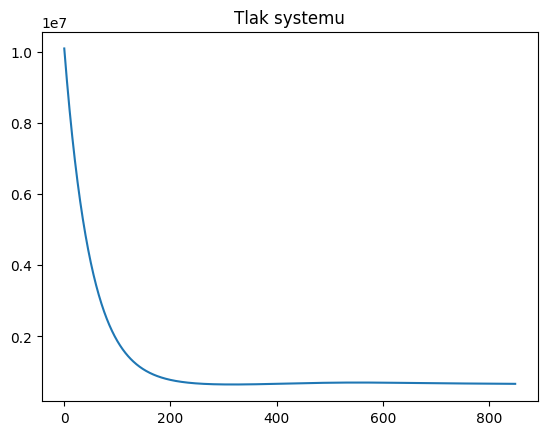

In [118]:
plt.plot(tlak_systemu[150:])
plt.title("Tlak systemu")

Text(0.5, 1.0, 'Prubeh potencialni energie')

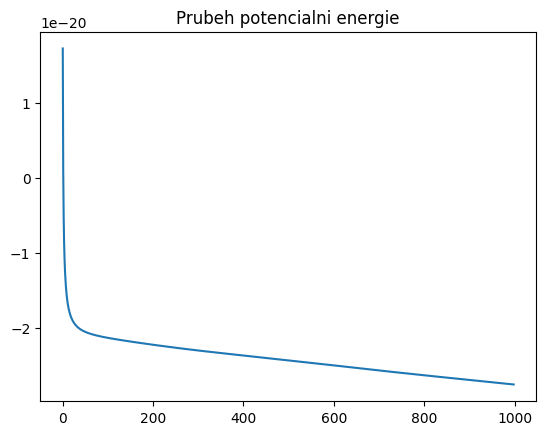

In [89]:
plt.plot(prubeh_e_pot[1:])
plt.title("Prubeh potencialni energie")

Text(0.5, 1.0, 'Prubeh kineticke energie')

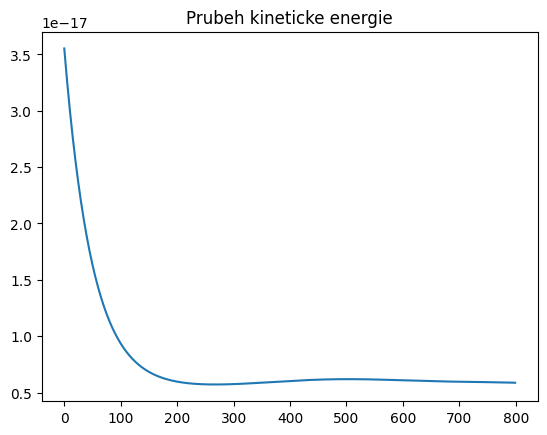

In [121]:
plt.plot(prubeh_e_kin[200:])
plt.title("Prubeh kineticke energie")

Text(0.5, 1.0, 'Prubeh celkove energie')

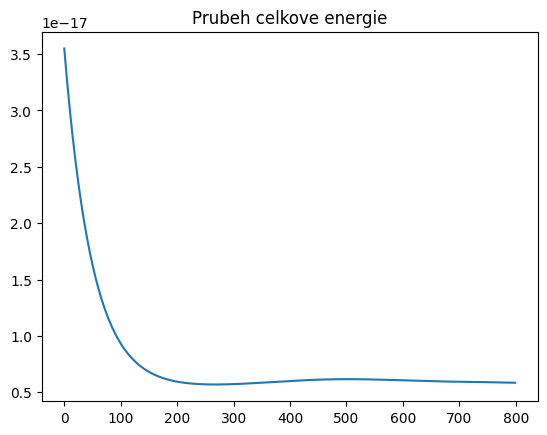

In [80]:
e_tot =  np.array(prubeh_e_kin) + np.array(prubeh_e_pot)
plt.plot(e_tot[200:])
plt.title("Prubeh celkove energie")

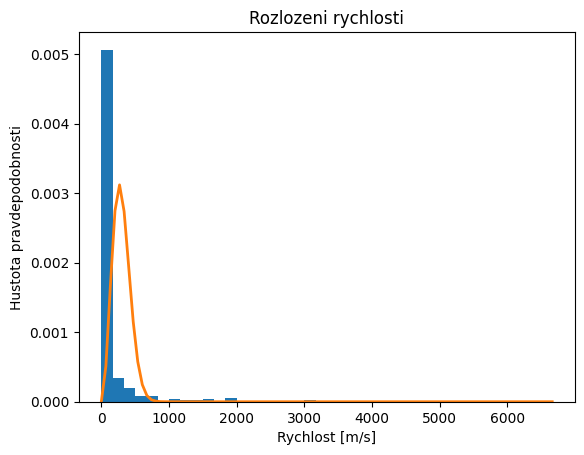

In [79]:
plot_rychlosti(akt_rychl, teplota, hmotnost_argonu, boltzmanova_konstanta)

Text(0.5, 1.0, 'Prubezna teplota s regulaci termostatu')

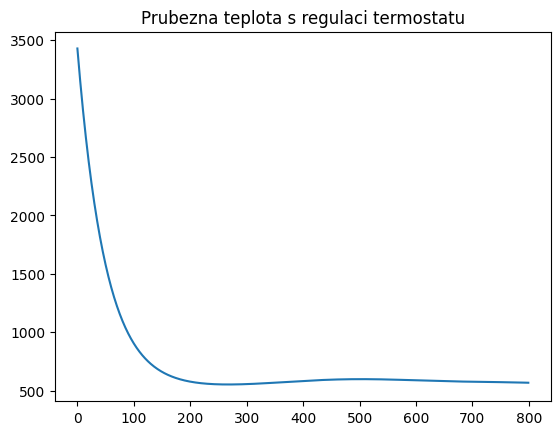

In [108]:
plt.plot(teploty_pred_zmenou[200:])
plt.title("Prubezna teplota s regulaci termostatu")

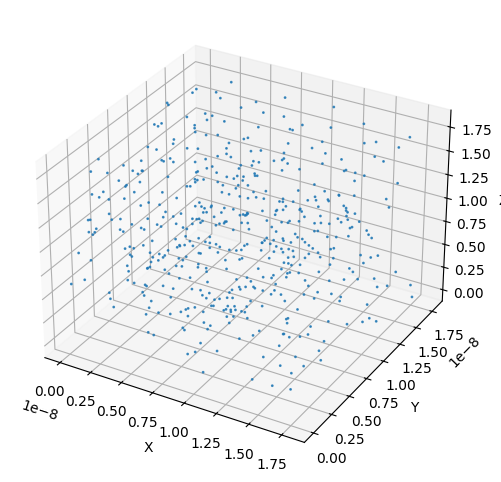

In [52]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(akt_polohy[:, 0], akt_polohy[:, 1], akt_polohy[:, 2], s=1, alpha=0.8)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [53]:
# with open("Vysleden_polohy_po_50000_iter.xyz", "w") as soubor_poloh:
#     for castice in akt_polohy:
#         soubor_poloh.write("Ar ")
#         soubor_poloh.write(" ".join(map(str, castice)) + "\n")

In [54]:
# with open("Rychlosti_po_50000_iter.txt", "w") as soubor_rychlosti:
#     for castice in akt_rychl:
#         soubor_rychlosti.write(" ".join(map(str, castice)) + "\n")